# Cargamos los datos y los visualizamos

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'./Caudal_Acumulado.csv', parse_dates=["Fecha"], index_col=["Fecha"])
df

,Lectura
Fecha,
2018-01-01 00:49:29,339229.0
2018-01-01 01:55:24,339237.0
2018-01-01 04:00:53,339247.0
2018-01-01 04:20:35,339249.0
2018-01-01 06:15:38,339257.0
...,...
2022-01-16 23:17:08,721306.0
2022-01-16 23:24:58,721307.0
2022-01-16 23:35:57,721308.0


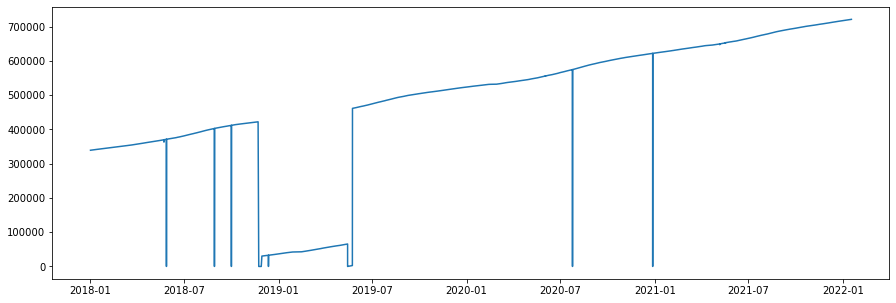

In [74]:
plt.figure(figsize=(15,5))
plt.plot(df)

# Para cada día dejamos únicamente la última muestra

In [75]:
df_ult_diario = df.reset_index().groupby([df.index.year,df.index.month,df.index.day],as_index=False).last().set_index('Fecha')
df_ult_diario

,Lectura
Fecha,
2018-01-01 08:15:24,339270.0
2018-01-02 22:49:22,339697.0
2018-01-03 23:55:07,339920.0
2018-01-04 23:38:58,340112.0
2018-01-05 23:43:36,340313.0
...,...
2022-01-12 23:54:01,720436.0
2022-01-13 23:54:52,720630.0
2022-01-14 23:53:27,720835.0


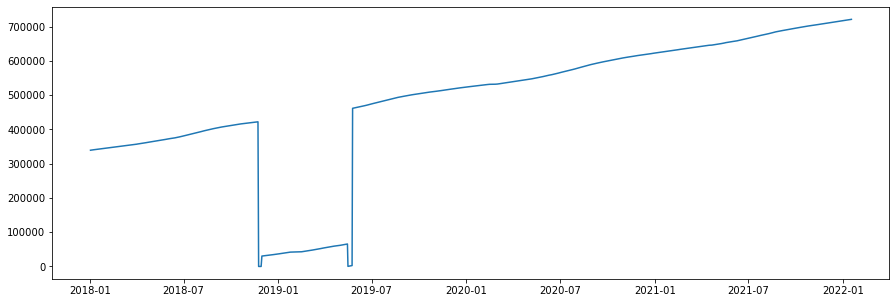

In [76]:
plt.figure(figsize=(15,5))
plt.plot(df_ult_diario)

# Restauramos la linealidad acumulativa del caudal

#### Como vemos, casi todas las veces en las que la medida del contador se deplomaba a 0 han desaparecido. Todas salvo la que provoca una ruptura de la linealidad del caudal acumulativo entre noviembre de 2018 y mayo de 2019. Lo solucionamos de la siguiente manera:
1) Como hay 6 días enteros con lectura 0 (23/11/2018 - 28/11/2018), calculamos el caudal que se consume en total en 6 días con medidas válidas.  
2) En la última muestra del día 28 colocamos el valor que le correspondería si todo hubiese ido bien, es decir, el caudal del día 22 más el caudal consumido en 6 días  
3) A todas las muestras entre el 29/11/2018 y el 15/05/2019 se les añade la cantidad necesaria para volver a recuperar la linealidad acumulativa del caudal.

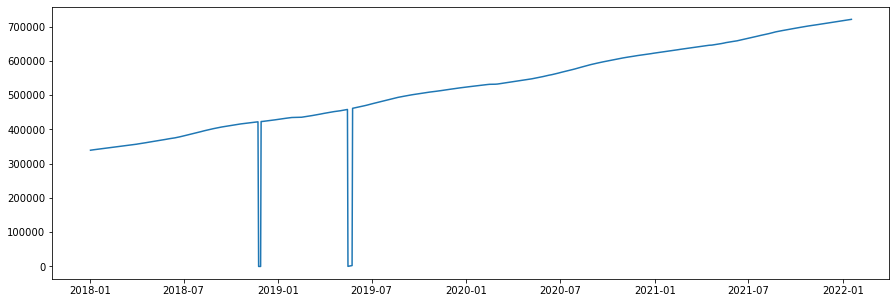

In [77]:
#1
semana16_22=df_ult_diario.loc['2018-11-16':'2018-11-21']
cant_semana16_22=semana16_22.iloc[-1].Lectura-semana16_22.iloc[0].Lectura

#2
df_ult_diario.loc["2018-11-28","Lectura"]=cant_semana16_22+df_ult_diario.loc["2018-11-22 08:40:34","Lectura"]

#3
cant_a_sumar = df_ult_diario.loc["2018-11-28 11:28:03","Lectura"]-df_ult_diario.loc["2018-11-29 23:28:31","Lectura"]
df_ult_diario.loc["2018-11-29 23:28:31":'2019-05-15 02:13:53',"Lectura"]+=cant_a_sumar

#Visualizamos
plt.figure(figsize=(15,5))
plt.plot(df_ult_diario)

#### Ya casi está. El último paso que vamos a dar es eliminar los valores que siguen siendo cero para rellenarlos con una interpolación lineal, pero que tiene en cuenta la separación temporal entre las muestras (https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html)

(0.0, 750000.0)

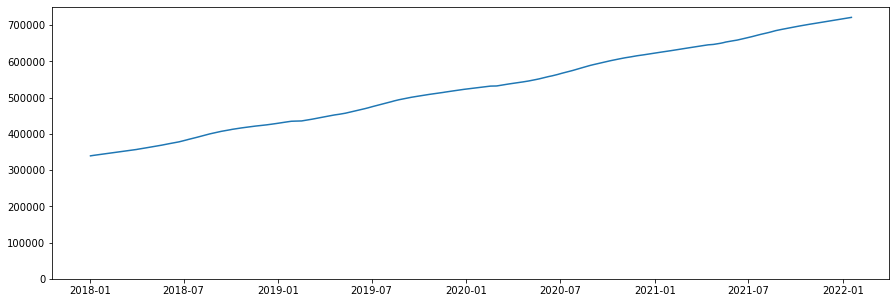

In [78]:
df_valid_dates = df_ult_diario.loc[(df_ult_diario['Lectura'] > 300000)]

for index, row in df_ult_diario.iterrows():
    if index not in df_valid_dates.index:
        row.Lectura = None
        
df_ult_diario = df_ult_diario.interpolate(method='time')

#Visualizamos
plt.figure(figsize=(15,5))
plt.plot(df_ult_diario)
plt.ylim(0,750000)

# Insertando valores en los instantes requeridos

Teniendo en cuenta que vamos a predecir diariamente. Nos interesa tener al menos una muestra diaria y que esta sea casi al final del día. De este modo, cuando transformemos la seria de caudal acumulado a caudal diario, la transformación se hará de la manera más equitativa posible.

Por tanto, vamos a introducir valores con la misma técnica de antes tanto en los días en los que no haya muestras, como en los días cuya última muestra sea anterior a las 23:15h.

In [79]:
from datetime import timedelta
d = df_ult_diario.index.date
date_set = set(d[0] + timedelta(x) for x in range((d[-1] - d[0]).days))
missing = sorted(date_set - set(d))
missing

[datetime.date(2018, 1, 26),
 datetime.date(2018, 1, 27),
 datetime.date(2018, 1, 28),
 datetime.date(2018, 1, 29),
 datetime.date(2018, 4, 3),
 datetime.date(2018, 5, 13),
 datetime.date(2018, 11, 24),
 datetime.date(2018, 11, 25),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 6, 9)]

In [80]:
import datetime
df_no_valid_dates= df_ult_diario.loc[df_ult_diario.index.time < datetime.datetime.strptime('23:15', '%H:%M').time()].index
df_no_valid_dates

DatetimeIndex(['2018-01-01 08:15:24', '2018-01-02 22:49:22',
               '2018-01-07 21:44:34', '2018-01-16 11:52:43',
               '2018-01-17 21:53:01', '2018-01-18 23:09:55',
               '2018-01-22 22:08:01', '2018-01-25 09:53:02',
               '2018-01-30 23:00:11', '2018-02-05 22:14:53',
               ...
               '2020-02-20 01:18:13', '2020-02-22 23:12:38',
               '2020-02-23 21:21:46', '2020-02-24 22:23:28',
               '2020-02-25 20:45:04', '2020-03-05 18:24:11',
               '2020-06-08 19:35:53', '2020-10-03 22:36:59',
               '2021-04-19 22:38:12', '2021-07-18 09:48:04'],
              dtype='datetime64[ns]', name='Fecha', length=121, freq=None)

In [81]:
adding_dates=[]
caudales = []
for date in df_no_valid_dates:
    # Evitamos insertar duplicados
    if date.date not in missing:
        adding_dates.append(pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + '23:59'))
        caudales.append(None)

for date in missing:
    if date not in df_no_valid_dates:
        # Evitamos insertar duplicados
        adding_dates.append(pd.to_datetime(date.strftime('%Y-%m-%d') + ' ' + '23:59'))
        caudales.append(None)    

df_to_add = pd.DataFrame(list(zip(adding_dates, caudales)))
df_to_add.columns = ['Fecha','Lectura']
df_to_add = df_to_add.set_index('Fecha')
df_ult_diario=pd.concat([df_ult_diario,df_to_add]).sort_values(by="Fecha")
df_ult_diario = df_ult_diario.interpolate(method='time')
df_ult_diario = df_ult_diario.reset_index().groupby([df_ult_diario.index.year,
                                                     df_ult_diario.index.month,
                                                     df_ult_diario.index.day],as_index=False).last().set_index('Fecha')

# Pasamos de caudal acumulado a caudal diario

Una vez que nos hemos asegurado de que nuestro conjunto de datos tiene para cada día una muestra válida, es decir, una muestra tomada después de las 23:15h con un valor coherente, podemos obtener una nueva serie temporal en la que, en lugar de tener para cada día el caudal acumulado, se tiene el caudal consumido durante ese día. Para ello, basta con restar al caudal acumulado del día t el caudal acumulado del día t-1.

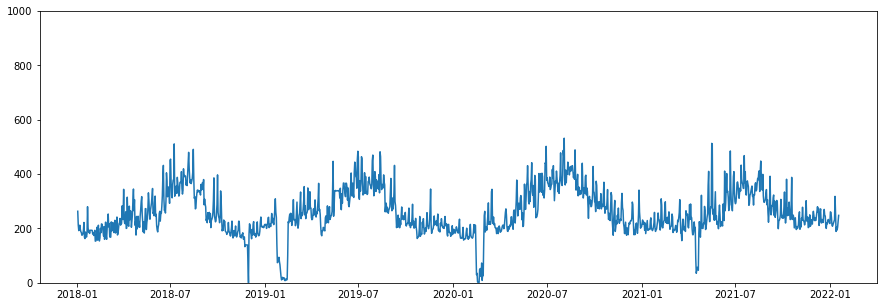

In [82]:
prev=0
caudal_diario=[]
for index,item in df_ult_diario.iterrows():
    caudal_diario.append(item[0]-prev)
    prev=item[0]

df_consumo_diario = pd.DataFrame()
df_consumo_diario.index = df_ult_diario.index
df_consumo_diario['Consumo']=caudal_diario
#Eliminamos la primera muestra por presentar un valor inconsistente
df_consumo_diario.drop(index=df_consumo_diario.index[0], axis=0, inplace=True)

#Visualizamos
plt.figure(figsize=(15,5))
plt.plot(df_consumo_diario)
plt.ylim(0,1000)
df_consumo_diario.to_csv("./consumo_diario_01.csv")

# Paliando las limpiezas del depósito

Como vemos en la gráfica de arriba, hay varias ocasiones en las que el consumo diario es bastante bajo en comparación al resto de los días.

Se consulta con los expertos y nos notifican que todos los años, se produce una limpieza en los depósitos que dura varios días. Durante este periodo, nuestro depósito de estudio está vacío y las medidas que se toman son nulas o erróneas. Como se ve, hay una en 2019 y otra en 2020 que se producen en torno a febrero, pero en 2021, se produce más tarde, en torno a Abril, debido al confinamiento que hubo por la pandemia.

De este modo, los expertos proponen sustituir los datos erróneos en esas fechas por datos en fechas próximas con valores correctos. En concreto, aseguran que el consumo de agua en hogares particulares presenta un comportamiento similar entre semanas de manera que los días laborables el consumo suele mantenerse estable, pero los fines de semana este crece considerablemente. Esto se puede apreciar claramente en las gráficas de abajo.

<AxesSubplot:title={'center':'Semanas de 2021'}>

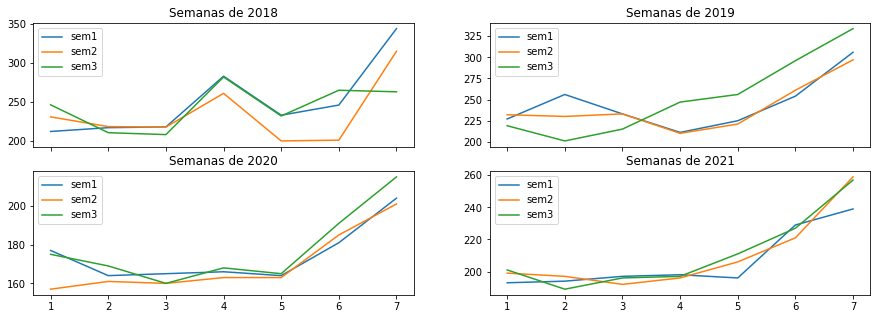

In [83]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,5))
dia=[1,2,3,4,5,6,7]

semana1_2018=df_consumo_diario.loc["2018-03-26":"2018-04-01",'Consumo'].values
semana2_2018=df_consumo_diario.loc["2018-04-02":"2018-04-08",'Consumo'].values
semana3_2018=df_consumo_diario.loc["2018-04-09":"2018-04-15",'Consumo'].values
d = {'sem1': semana1_2018,'sem2': semana2_2018,'sem3': semana3_2018}
semanas2018 = pd.DataFrame(data=d,index=dia)
semanas2018.plot(title='Semanas de 2018', ax=axes[0][0], label='Actual')

semana1_2019=df_consumo_diario.loc["2019-02-18":"2019-02-24",'Consumo'].values
semana2_2019=df_consumo_diario.loc["2019-02-25":"2019-03-03",'Consumo'].values
semana3_2019=df_consumo_diario.loc["2019-03-04":"2019-03-10",'Consumo'].values
d = {'sem1': semana1_2019,'sem2': semana2_2019,'sem3': semana3_2019}
semana1_2019 = pd.DataFrame(data=d,index=dia)
semana1_2019.plot(title='Semanas de 2019', ax=axes[0][1], label='Actual')

semana1_2020=df_consumo_diario.loc["2020-01-13":"2020-01-19",'Consumo'].values
semana2_2020=df_consumo_diario.loc["2020-01-20":"2020-01-26",'Consumo'].values
semana3_2020=df_consumo_diario.loc["2020-01-27":"2020-02-02",'Consumo'].values
d = {'sem1': semana1_2020,'sem2': semana2_2020,'sem3': semana3_2020}
semana1_2020 = pd.DataFrame(data=d,index=dia)
semana1_2020.plot(title='Semanas de 2020', ax=axes[1][0], label='Actual')

semana1_2021=df_consumo_diario.loc["2021-01-11":"2021-01-17",'Consumo'].values
semana2_2021=df_consumo_diario.loc["2021-01-18":"2021-01-24",'Consumo'].values
semana3_2021=df_consumo_diario.loc["2021-01-25":"2021-01-31",'Consumo'].values
d = {'sem1': semana1_2021,'sem2': semana2_2021,'sem3': semana3_2021}
semanas2021 = pd.DataFrame(data=d,index=dia)
semanas2021.plot(title='Semanas de 2021', ax=axes[1][1], label='Actual')



Por lo tanto, los valores que presentan las irregularidades relacionados con el vaciado de depósitos, serán sustituidos por valores correctos que pertenezcan al mismo día de la semana. Por ejemplo, si una de estas irregularidades se produce un miércoles, su valor será sustituido por el valor del miércoles más próximo con un valor coherente.  

Hacemos estas sustituciones manualmente fuera de este notebook y el resultado se muestra más abajo.

,Consumo
Fecha,
2018-01-02 23:59:00,263.188594
2018-01-03 23:55:07,212.687376
2018-01-04 23:38:58,192.000000
2018-01-05 23:43:36,201.000000
2018-01-06 23:49:11,212.000000
...,...
2022-01-12 23:54:01,205.000000
2022-01-13 23:54:52,194.000000
2022-01-14 23:53:27,205.000000


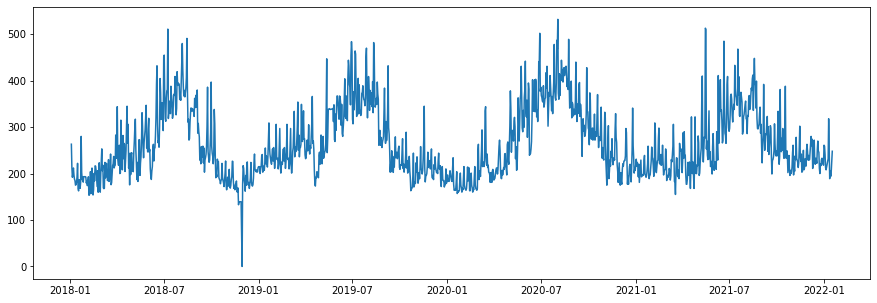

In [84]:
from datetime import datetime

df_consumo_diario = pd.read_csv(r'./consumo_diario_02.csv', parse_dates=["Fecha"], index_col=["Fecha"])

plt.figure(figsize=(15,5))
plt.plot(df_consumo_diario)
df_consumo_diario

# Detección de outliers por el método de rango intercuartílico

https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [85]:
# En caudal 1
Q1=df_consumo_diario['Consumo'].quantile(0.25)
Q3=df_consumo_diario['Consumo'].quantile(0.75)
IQR=Q3-Q1
Lim_alto=Q3+1.5*IQR
Lim_bajo=Q3-1.5*IQR

print('Numero de outliers valor alto (mayores de ',Lim_alto,'): ',df_consumo_diario[df_consumo_diario.Consumo>Lim_alto].shape[0])
print('Indicación de las muestras con outliers (valor alto): ')
outliersIndex = df_consumo_diario[df_consumo_diario.Consumo>Lim_alto].index
print(df_consumo_diario[df_consumo_diario.Consumo>Lim_alto])

print('Numero de outliers valor bajo (menores de ',Lim_bajo,'):',df_consumo_diario[df_consumo_diario.Consumo<Lim_bajo].shape[0])
print('Indicación de las muestras con outliers (valor bajo): ')
print(df_consumo_diario[df_consumo_diario.Consumo<Lim_bajo])
outliersIndex = outliersIndex.append(df_consumo_diario[df_consumo_diario.Consumo<Lim_bajo].index)

Numero de outliers valor alto (mayores de  487.0 ):  7
Indicación de las muestras con outliers (valor alto): 
                     Consumo
Fecha                       
2018-07-08 23:39:11    511.0
2018-08-14 23:43:59    491.0
2020-06-28 23:57:22    502.0
2020-08-02 23:57:46    532.0
2020-08-23 23:51:56    489.0
2021-05-15 23:55:44    513.0
2021-05-16 23:58:57    510.0
Numero de outliers valor bajo (menores de  151.0 ): 8
Indicación de las muestras con outliers (valor bajo): 
                        Consumo
Fecha                          
2018-11-22 23:59:00  132.845493
2018-11-23 23:59:00  139.299724
2018-11-24 23:59:00  139.299724
2018-11-25 23:59:00  139.299724
2018-11-26 23:59:00  139.299724
2018-11-27 23:59:00  139.299724
2018-11-28 23:59:00   66.655885
2018-11-29 23:28:31    0.000000


Como vemos, se han detectado 15 outliers con este método. 7 por encima de 1,5 veces el rango intercuartílico y 8 por debajo de 1,5 veces el rango intercuartílico

# Probando diferentes métodos de rellenado de datos para reemplazar los outliers

Nuestro próximo objetivo es reemplazar los 15 outliers. Para ello realizaremos el siguiente proceso:  
1) Observando la gráfica anterior, nos damos cuenta de que el año 2020 presenta menos irregularidades. Por tanto, seleccionaremos este año para realizar el estudio.  
2) De el año 2020, eliminaremos un 7% de los datos que sabemos que no son outliers.  
3) Basándonos en el post https://www.machinelearningplus.com/time-series/time-series-analysis-python/, analizaremos diferentes técnicas para rellenar esos datos eliminados y compararemos el error MSE cometido por cada una de ellas.  
4) La técnica que menor MSE presente, será la seleccionada para rellenar los outliers de toda la serie temporal

(0.0, 1000.0)

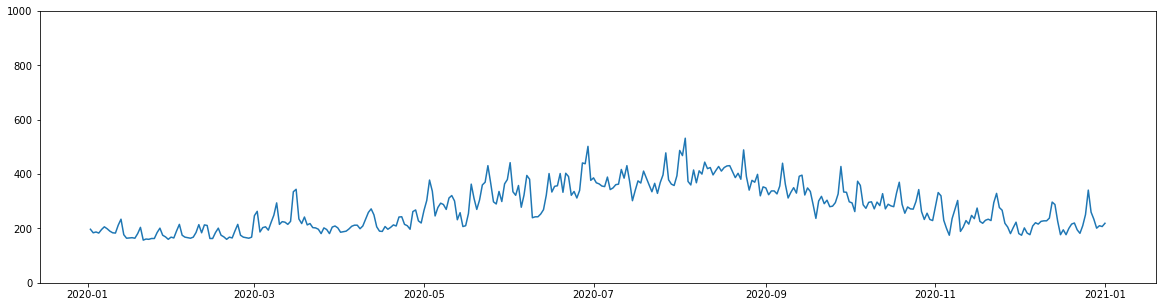

In [86]:
####1)
df2020 = df_consumo_diario.loc['2020-01-01':'2020-12-31']
df2020
plt.figure(figsize=(20,5))
plt.plot(df2020['Consumo'])
plt.ylim([0,1000])

C:\Users\ALEX\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:title={'center':'Seasonal Mean (MSE: 288.83)'}, xlabel='Fecha'>

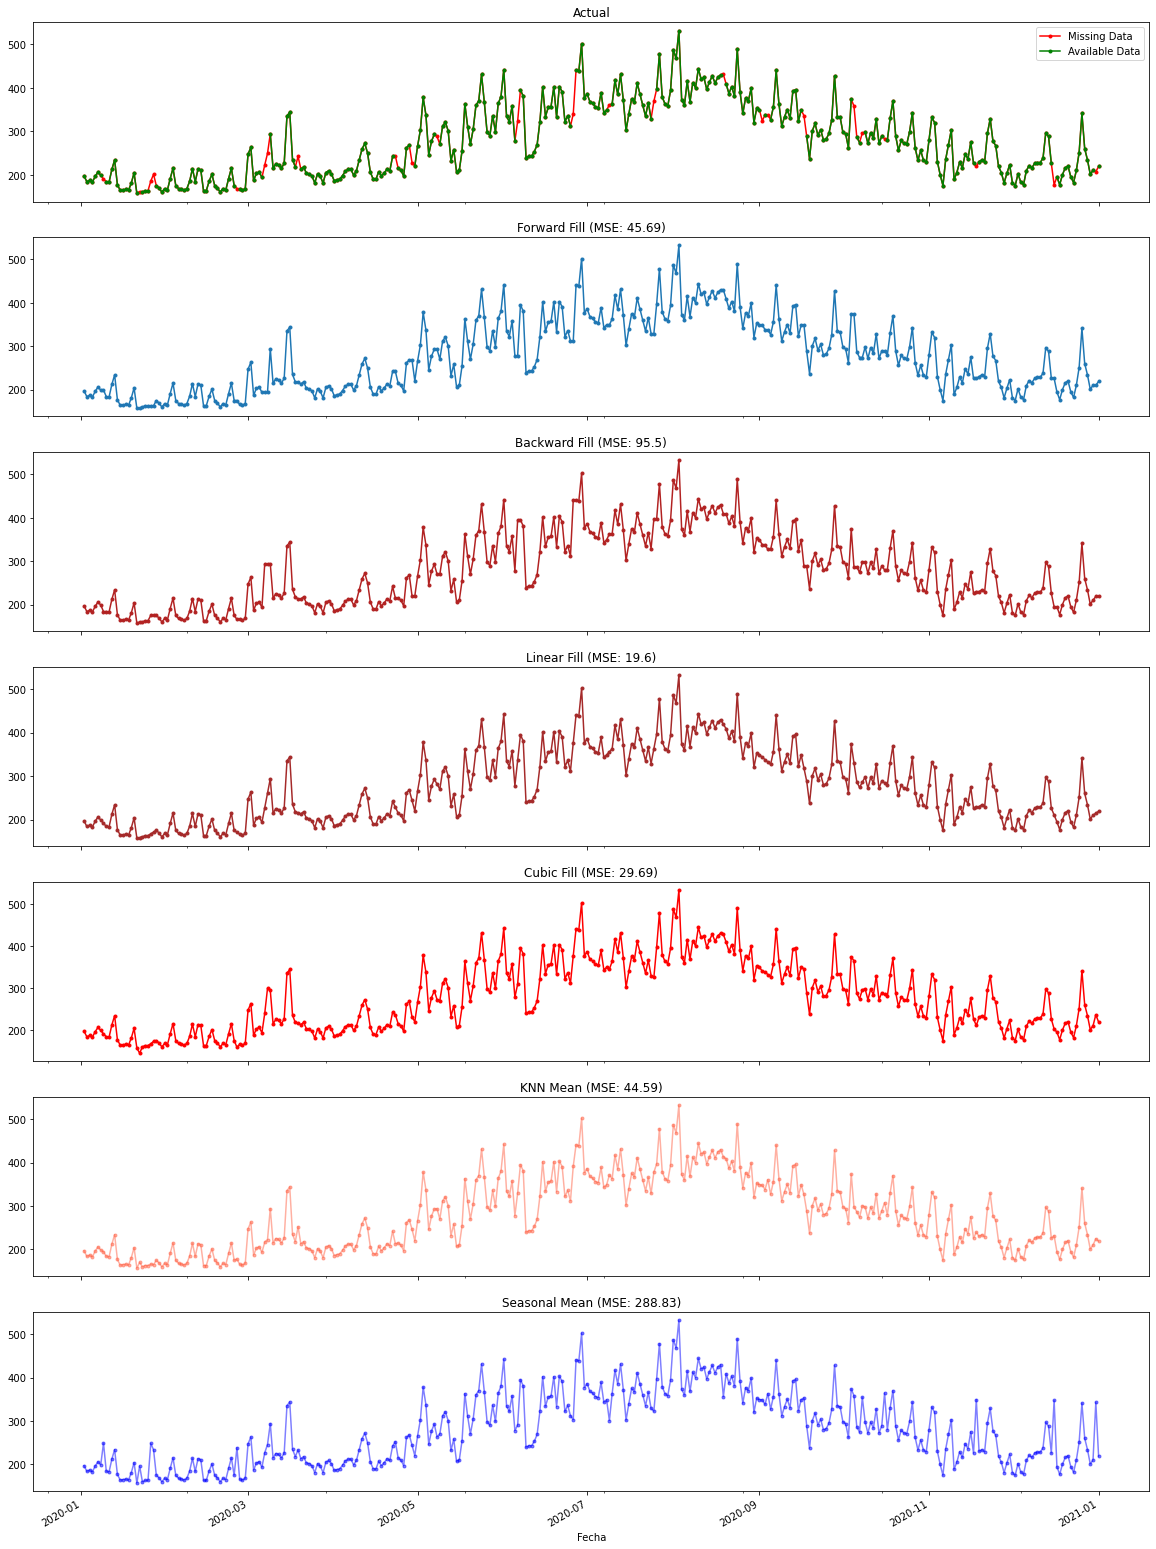

In [87]:
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(2)

####2)
df_orig = df2020
df_orig.rename(columns={'Consumo': 'Caudal'}, inplace=True)

df_valid_dates = df_orig.loc[~df_orig.index.isin(outliersIndex)].sample(frac = 0.07)
nan_valid = []
for index in df_orig.index:
    if index in df_valid_dates.index:
        nan_valid.append([True])
    else:
        nan_valid.append([False])

df = df_orig.mask(nan_valid)

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(20, 30))
plt.rcParams.update({'xtick.bottom' : False})

####3)
## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['Caudal'], df_ffill['Caudal']), 2)
df_ffill['Caudal'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['Caudal'], df_bfill['Caudal']), 2)
df_bfill['Caudal'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['Caudal'])
f = interp1d(df_nona['rownum'], df_nona['Caudal'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['Caudal'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Linear Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['Caudal'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['Caudal'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.Caudal, 8)
error = np.round(mean_squared_error(df_orig['Caudal'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.Caudal, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['Caudal'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

Como podemos ver, la técnica de rellenado de datos que menor MSE presenta es 'Linear Fill', es decir, relleno lineal. Esta técnica lo que hace es unir con una línea recta aquellos puntos entre los que hay un dato que rellenar.  
Se puede apreciar mejor su funcionamiento en la gráfica de abajo.

<AxesSubplot:title={'center':'Linear Fill'}, xlabel='Fecha'>

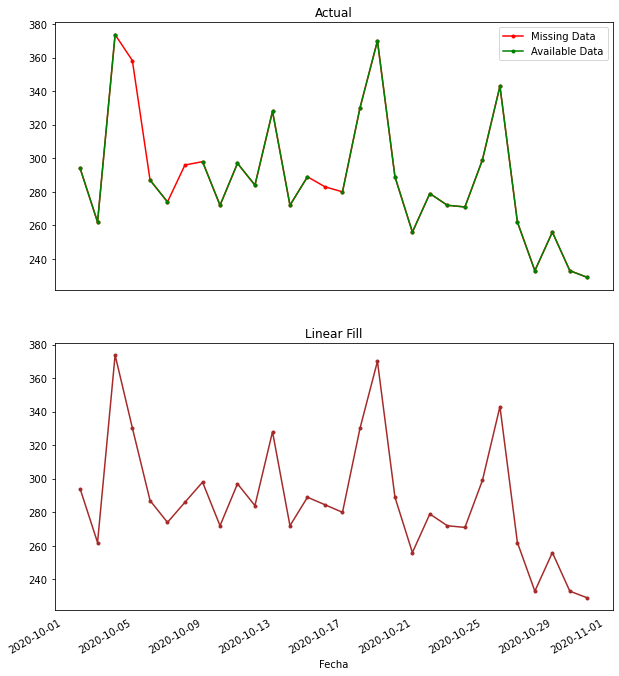

In [88]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 12))
df_orig.loc['2020-10-01':'2020-10-30'].plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df['Caudal'].loc['2020-10-01':'2020-10-30'].plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])
df['linear_fill'].loc['2020-10-01':'2020-10-30'].plot(title="Linear Fill", ax=axes[1], label='Linear Fill', color='brown', style=".-")

Por último, eliminamos los outliers para reemplazar sus valores con los generados por el relleno lineal. Esta es la serie temporal obtenida después de todo el preprocesado y será la utilizada para generar el dataset que se empleará en la generación de los diferentes modelos en los siguiente notebooks.

In [89]:
df_consumo_diario = pd.read_csv(r'./consumo_diario_02.csv', parse_dates=["Fecha"], index_col=["Fecha"])
for index, row in df_consumo_diario.iterrows():
    if index in outliersIndex:
        df_consumo_diario.loc[index,"Consumo"] = None

(0.0, 1000.0)

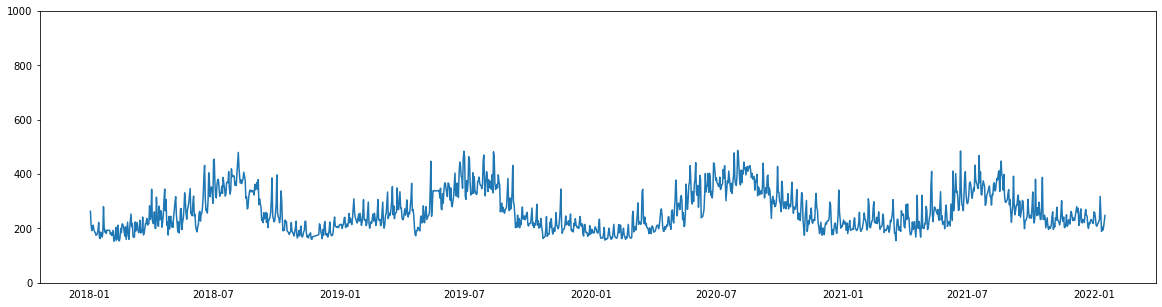

In [90]:
df_consumo_diario = df_consumo_diario.interpolate(method='time')
plt.figure(figsize=(20,5))
plt.plot(df_consumo_diario['Consumo'])
plt.ylim([0,1000])

In [91]:
df_consumo_diario.to_csv('./consumo_diario_03.csv')

# Generando y añadiendo las variables predictoras

Es momento de generar un dataset que presente la forma de un problema de aprendizaje supervisado. Para ello, necesitamos crear las variables predictoras. Por un lado, en relación al consumo, tomaremos dos caminos: el primero será tomar una ventana temporal de 7 días, es decir, para predecir el consumo(t) utilizaremos las observaciones de los 7 días anteriores. El otro camino, será tomar una ventana temporal de 14 días.  

Además, añadiremos información en relación al día que queremos predecir. Este tipo de información abarca desde que día de la semana/mes es hasta si el día es festivo/fin de semana o no. Además, añadiremos información climatológica que puede presentar relación con el consumo de agua, como temperatura y precipitaciones.  

Por tanto, generearemos 4 conjuntos de datos diferentes:
- Ventana temporal 7 días, sin información en relación al día.
- Ventana temporal 7 días, con información en relación al día.
- Ventana temporal 14 días, sin información en relación al día.
- Ventana temporal 14 días, con información en relación al día.

In [92]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Consumo(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Consumo(t)') for j in range(n_vars)]
        else:
            names += [('Consumo(t+%d)' % i) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    agg.set_index(agg.index.date, inplace=True)
    agg.index.name = 'Fecha'
    return agg

In [93]:
df = pd.read_csv('./consumo_diario_03.csv', parse_dates=["Fecha"], index_col=["Fecha"])
df_7d_no_info = series_to_supervised(df,7,1)
display(df_7d_no_info)
df_14d_no_info = series_to_supervised(df,14,1)
df_7d_no_info.to_csv('./consumo_diario_03_7d_no_info.csv')
df_14d_no_info.to_csv('./consumo_diario_03_14d_no_info.csv')

,Consumo(t-7),Consumo(t-6),Consumo(t-5),Consumo(t-4),Consumo(t-3),Consumo(t-2),Consumo(t-1),Consumo(t)
Fecha,,,,,,,,
2018-01-09,263.188594,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.0
2018-01-10,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.0
2018-01-11,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.0
2018-01-12,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.0
2018-01-13,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.000000,193.0
...,...,...,...,...,...,...,...,...
2022-01-12,214.000000,220.000000,227.000000,232.000000,318.000000,254.000000,189.000000,205.0
2022-01-13,220.000000,227.000000,232.000000,318.000000,254.000000,189.000000,205.000000,194.0
2022-01-14,227.000000,232.000000,318.000000,254.000000,189.000000,205.000000,194.000000,205.0


In [94]:
# Cargamos los datos de climatología
df_clima= pd.read_excel(r'./AEMET_2018_2022.xlsx',header=0,usecols=[0,5,6,7,9],parse_dates = ['fecha'],
                        index_col='fecha')
df_clima['tmed'] = df_clima['tmed'].apply(lambda x: float(x.replace(',','.')))

        
for i, row in df_clima.iterrows():
    if row['prec'] == "Ip":
        df_clima.at[i,'prec'] = "0.0"
df_clima['prec'] = df_clima['prec'].apply(lambda x: float(x.replace(',','.')))

df_clima['tmin'] = df_clima['tmin'].apply(lambda x: float(x.replace(',','.')))

df_clima['tmax'] = df_clima['tmax'].apply(lambda x: float(x.replace(',','.')))
df_clima

,tmed,prec,tmin,tmax
fecha,,,,
2018-01-01,14.0,0.0,6.8,21.1
2018-01-02,15.0,0.0,8.0,22.1
2018-01-03,17.2,0.0,11.5,22.9
2018-01-04,18.2,0.0,11.2,25.3
2018-01-05,14.7,0.0,8.1,21.3
...,...,...,...,...
2022-01-12,12.0,0.4,6.7,17.2
2022-01-13,10.0,0.0,5.2,14.8
2022-01-14,8.4,0.0,3.1,13.7


In [95]:
df_7d_info = df_7d_no_info.copy()

df_7d_info['DateTime'] = df_7d_info.index

df_7d_info['Dia_semana'] = df_7d_info['DateTime'].apply(lambda x: x.weekday()) # Día de la semana
df_7d_info['Dia_mes'] = df_7d_info['DateTime'].apply(lambda x: x.day) # Día del mes
df_7d_info['Mes'] = df_7d_info['DateTime'].apply(lambda x: x.month) # Día del mes 
df_7d_info['Fin_de_semana']=0
df_7d_info.loc[df_7d_info.Dia_semana >= 5, 'Fin_de_semana'] = 1
df_7d_info = df_7d_info.drop(['DateTime'],axis=1)

# DIAS FESTIVOS
# https://www.calendarioslaborales.com/calendario-laboral-murcia-2018.htm
df_7d_info['Festivo'] = 0
dias_festivos=['2018-03-19','2018-03-29','2018-03-30','2018-04-03','2018-05-01','2018-06-09',
               '2018-08-15','2018-09-11','2018-10-12','2018-11-01','2018-12-06','2018-12-08','2018-12-25',
               '2019-01-01','2019-01-07','2019-03-19','2019-04-18','2019-04-19','2019-04-23','2019-05-01',
               '2019-06-10','2019-08-15','2019-09-17','2019-10-12','2019-11-01','2019-12-06','2019-12-25',
               '2020-01-01','2020-01-06','2020-03-19','2020-04-09','2020-04-10','2020-04-14','2020-05-01',
               '2020-06-09','2020-08-15','2020-09-15','2020-10-12','2020-12-07','2020-12-08','2020-12-25',
               '2021-01-01','2021-01-06','2021-03-19','2021-04-01','2021-04-02','2021-04-06','2021-05-01',
               '2021-06-09','2021-09-13','2021-10-12','2021-11-01','2021-12-06','2021-12-08','2021-12-25',
               '2022-01-01','2022-01-06']
for dia in dias_festivos:
    df_7d_info.loc[dia,'Festivo']=1
    
df_7d_info = df_7d_info.dropna()
    
# DATOS CLIMÁTICOS
df_7d_info['Tmed'] = df_clima.loc[df_7d_info.index[0]:df_7d_info.index[-1]:,'tmed']          # Temperatura media
df_7d_info['Tmin'] = df_clima.loc[df_7d_info.index[0]:df_7d_info.index[-1]:,'tmin']          # Temperatura máxima
df_7d_info['Tmax'] = df_clima.loc[df_7d_info.index[0]:df_7d_info.index[-1]:,'tmax']          # Temperatura máxima
df_7d_info['Precipit'] = df_clima.loc[df_7d_info.index[0]:df_7d_info.index[-1]:,'prec']    # Precipitación 

df_7d_info = df_7d_info.astype({'Dia_semana': 'int8', 'Dia_mes': 'int8',
                                'Mes': 'int8', 'Fin_de_semana': 'int8', 'Festivo': 'int8'})
display(df_7d_info.head())
df_7d_info.to_csv('./consumo_diario_03_7d_info.csv')

,Consumo(t-7),Consumo(t-6),Consumo(t-5),Consumo(t-4),Consumo(t-3),Consumo(t-2),Consumo(t-1),Consumo(t),Dia_semana,Dia_mes,Mes,Fin_de_semana,Festivo,Tmed,Tmin,Tmax,Precipit
Fecha,,,,,,,,,,,,,,,,,
2018-01-09,263.188594,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.0,1,9,1,0,0,7.5,0.7,14.3,3.8
2018-01-10,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.0,2,10,1,0,0,12.8,7.0,18.7,0.0
2018-01-11,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.0,3,11,1,0,0,12.4,8.7,16.2,0.2
2018-01-12,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.0,4,12,1,0,0,11.0,4.5,17.6,0.0
2018-01-13,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.000000,193.0,5,13,1,1,0,9.6,4.0,15.2,0.0


In [96]:
df_14d_info = df_14d_no_info.copy()

df_14d_info['DateTime'] = df_14d_info.index

df_14d_info['Dia_semana'] = df_14d_info['DateTime'].apply(lambda x: x.weekday()) # Día de la semana
df_14d_info['Dia_mes'] = df_14d_info['DateTime'].apply(lambda x: x.day) # Día del mes
df_14d_info['Mes'] = df_14d_info['DateTime'].apply(lambda x: x.month) # Día del mes 
df_14d_info['Fin_de_semana']=0
df_14d_info.loc[df_14d_info.Dia_semana >= 5, 'Fin_de_semana'] = 1
df_14d_info = df_14d_info.drop(['DateTime'],axis=1)

# DIAS FESTIVOS
# https://www.calendarioslaborales.com/calendario-laboral-murcia-2018.htm
df_14d_info['Festivo'] = 0
dias_festivos=['2018-03-19','2018-03-29','2018-03-30','2018-04-03','2018-05-01','2018-06-09',
               '2018-08-15','2018-09-11','2018-10-12','2018-11-01','2018-12-06','2018-12-08','2018-12-25',
               '2019-01-01','2019-01-07','2019-03-19','2019-04-18','2019-04-19','2019-04-23','2019-05-01',
               '2019-06-10','2019-08-15','2019-09-17','2019-10-12','2019-11-01','2019-12-06','2019-12-25',
               '2020-01-01','2020-01-06','2020-03-19','2020-04-09','2020-04-10','2020-04-14','2020-05-01',
               '2020-06-09','2020-08-15','2020-09-15','2020-10-12','2020-12-07','2020-12-08','2020-12-25',
               '2021-01-01','2021-01-06','2021-03-19','2021-04-01','2021-04-02','2021-04-06','2021-05-01',
               '2021-06-09','2021-09-13','2021-10-12','2021-11-01','2021-12-06','2021-12-08','2021-12-25',
               '2022-01-01','2022-01-06']
for dia in dias_festivos:
    df_14d_info.loc[dia,'Festivo']=1
    
df_14d_info = df_14d_info.dropna()
    
# DATOS CLIMÁTICOS
df_14d_info['Tmed'] = df_clima.loc[df_14d_info.index[0]:df_14d_info.index[-1]:,'tmed']          # Temperatura media
df_14d_info['Tmin'] = df_clima.loc[df_14d_info.index[0]:df_14d_info.index[-1]:,'tmin']          # Temperatura máxima
df_14d_info['Tmax'] = df_clima.loc[df_14d_info.index[0]:df_14d_info.index[-1]:,'tmax']          # Temperatura máxima
df_14d_info['Precipit'] = df_clima.loc[df_14d_info.index[0]:df_14d_info.index[-1]:,'prec']    # Precipitación 

df_14d_info = df_14d_info.astype({'Dia_semana': 'int8', 'Dia_mes': 'int8',
                                'Mes': 'int8', 'Fin_de_semana': 'int8', 'Festivo': 'int8'})
display(df_14d_info.head())
df_14d_info.to_csv('./consumo_diario_03_14d_info.csv')

,Consumo(t-14),Consumo(t-13),Consumo(t-12),Consumo(t-11),Consumo(t-10),Consumo(t-9),Consumo(t-8),Consumo(t-7),Consumo(t-6),Consumo(t-5),...,Consumo(t),Dia_semana,Dia_mes,Mes,Fin_de_semana,Festivo,Tmed,Tmin,Tmax,Precipit
Fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-16,263.188594,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.0,175.0,176.0,...,162.687726,1,16,1,0,0,12.0,3.0,21.1,0.0
2018-01-17,212.687376,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.0,176.0,181.0,...,186.760161,2,17,1,0,0,14.8,7.9,21.7,0.0
2018-01-18,192.000000,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.0,181.0,193.0,...,176.329748,3,18,1,0,0,12.4,6.7,18.2,0.0
2018-01-19,201.000000,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.0,193.0,222.0,...,168.222365,4,19,1,0,0,11.8,7.3,16.4,0.0
2018-01-20,212.000000,196.917293,188.082707,185.000000,175.000000,176.000000,181.000000,193.0,222.0,168.0,...,181.000000,5,20,1,1,0,14.8,6.9,22.8,0.0
